# Surface Radiation Budget's Surface Downwelling Shortwave Flux intercomparison for solar energy applications


Production date: 11-06-2025

Produced by: CNR-ISMAR, Claudia Allegrini, Andrea Storto, Vincenzo de Toma

## 🌍 Use case: Use of satellite radiation data in the solar energy sector

## ❓ Quality assessment question(s)
* **How consistent are the satellite-based Surface Downwelling Shortwave Flux from CLARA-A3 with the ERA5 Reanalysis?**

This notebook provides a quantitative consistency assessment of two key shortwave radiation products essential for solar energy resource planning. The approach involves a direct spatio-temporal comparison between the satellite-derived CLARA-A3 Surface Downwelling Shortwave Flux and the ERA5 reanalysis analogue, the mean surface downward shortwave radiation flux. The goal is to evaluate the agreement, quantify potential systematic biases, and assess the overall quality and uncertainty of the CLARA-A3 data when inter-compared with ERA5 Reanalysis. This intercomparison could provide insights for users interested in using these datasets for solar energy applications.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* There is strong spatial and temporal agreement between the satellite-derived CLARA-A3 Surface Downwelling Shortwave Flux and the ERA5 reanalysis product, with both datasets capturing key global radiation patterns and seasonal cycles effectively.
* CLARA-A3 is well-suited for solar energy applications, providing accurate estimates of surface shortwave radiation during sunlit periods and avoiding some of the structural overestimations found in ERA5; however, users must consider limitations such as lower data availability in polar night and early satellite sensor periods.
* Combining CLARA-A3 and ERA5 leverages their complementary strengths: satellite observations for validation and high-fidelity local cloud effects, and ERA5 for continuous, spatially complete data, enhancing solar resource assessment and energy yield modeling, when appropriate multi-source bias corrections techniques are applied.
```

```{figure} attachment:8d29d45c-5d47-466c-a42f-0652c5263b73.png
Mean Bias between CLARA-A3 and ERA5 Surface Solar Radiation for the period 1979-2020
```
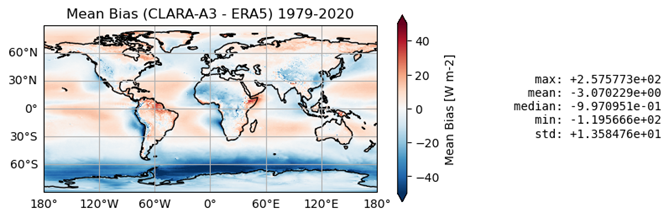

## 📋 Methodology

This quality assessment utilises a direct, cell-by-cell spatio-temporal comparison between two distinct sources of Surface Shortwave Radiation (SSR) products within the Copernicus Climate Change (C3S) Climate Data Store (CDS). Respectively, the catalogue entries are: 
1. CLARA-A3 Surface Downwelling Shortwave Flux (SIS) (Satellite-Derived): This product is derived from satellite observations as part of the third generation of the CM SAF cLoud, Albedo, and Radiation dataset from AVHRR (CLARA-A3). It provides global coverage of monthly mean of surface downwelling shortwave flux, calculated through radiative transfer models applied to cloud and surface properties retrieved from satellite instruments. This dataset represents observational estimates of the amount of shortwave radiation energy reaching the lower boundary of the atmosphere per unit of time and area from above. (for further information see [CLARA-A3 Overview Page](https://cds.climate.copernicus.eu/datasets/satellite-surface-radiation-budget?tab=overview)).
2. ERA5 Mean Downward Short Wave Radiation Flux (avg_sdswrf) (Reanalysis Model): The ERA5 product is the fifth-generation ECMWF atmospheric reanalysis, providing hourly estimates of atmospheric, land, and oceanic variables. avg_sdswrf is not a direct observation but is the result of numerical weather prediction and climate models assimilating vast amounts of global data, and provided as a monthly averaged flux. It is considered a highly consistent and frequently used reference dataset for energy and climate studies due to its stability and high resolution. (for further detail see [ERA5 Overview Page](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview)).

The comparison involves co-locating the CLARA-A3 and ERA5 datasets in both space and time to ensure a fair comparison of corresponding grid cells and timestamps. The analysis focuses on showing the percentage of valid data points in time and space, selected fixing a given threshold on the number of daily measurements used to derive the monthly average in CLARA-A3, applying the same mask to ERA5, and showing diagnostics such as annual cycles globally and regionally, and mean maps on the common coverage period between the satellite-derived and reanalysis products.
The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](choose-the-data-to-use-and-setup-code)**

**[](download-and-transform)**

**[](plot-spatial-weighted-time-series)**

**[](plot-time-weighted-means)**

**[](plot-spatial-weighted-zonal-means)**

## 📈 Analysis and results

(choose-the-data-to-use-and-setup-code)=
### 1. Data Definition and Setup

This section sets the stage for the analysis by defining all necessary parameters and utility functions. The study is established to cover the extended period from January 1979 to December 2020, and the core variable is the downwelling shortwave flux (SIS for CLARA-A3, avg_sdswrf for ERA5). Three distinct regions — global, northern hemisphere, and southern hemisphere — are defined for focused temporal analysis. Furthermore, this step specifies the exact metadata required to retrieve both the CLARA-A3 satellite data and the ERA5 reanalysis data from their respective Copernicus Climate Data Store collections.

In [1]:
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/detoma_vincenzo/.cdsapirc")
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from cartopy import crs as ccrs, feature as cfeature
import cartopy.mpl.ticker as cticker
from c3s_eqc_automatic_quality_control import download, plot, utils, diagnostics
import warnings
warnings.filterwarnings("ignore")

# Variable to analyse
variable = "downwelling_shortwave"

# Region for timeseries
region_slices = {
    "global": {"lat_slice": slice(-90, 90), "lon_slice": slice(0, 360)},
    "northern hemisphere": {"lat_slice": slice(0, 90), "lon_slice": slice(0, 360)},
    "southern hemisphere": {"lat_slice": slice(-90, 0), "lon_slice": slice(0, 360)},
}

collection_ids = ["satellite-surface-radiation-budget", "reanalysis-era5-single-levels-monthly-means"]
chunks = {"year": 1}

# Define request_dict
request_dict = {
    "CLARA_A3": {
        "start": "1979-01", 
        "stop": "2020-12", 
        "product_family": "clara_a3",
        "origin": "eumetsat",
        "variable": f"surface_{variable}_flux",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
    },
    "ERA5": {
        "start":"1979-01", 
        "stop" :"2020-12", 
        "product_type": "monthly_averaged_reanalysis",
        "time": "00:00",
        "data_format": "grib",
        "download_format": "zip",
        "variable": "mean_surface_downward_short_wave_radiation_flux",
    }
}

# Create the list with the dictionary
request_dicts = [request_dict]

def preprocess_time(ds):
    if "time" in ds and "units" in ds["time"].attrs:
        # Could not decode
        ds = ds.squeeze("time", drop=True)
    if "time" not in ds:
        time = pd.to_datetime(ds.attrs["time_coverage_start"].replace("Z", ""))
        ds = ds.expand_dims(time=[time])
    return ds

def spatial_weighted_mean(ds, lon_slice, lat_slice, regrid, ds_obj, SKIP, mask=None):
    if mask is None:
        if regrid==True:
            ds = diagnostics.regrid(ds, ds_obj, method='bilinear', skipna=SKIP)
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
        return diagnostics.spatial_weighted_mean(ds, weights=True, skipna=SKIP)
    else:
        if regrid==True:
            ds = diagnostics.regrid(ds, ds_obj, method='bilinear', skipna=SKIP)
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
        mask = utils.regionalise(mask, lon_slice=lon_slice, lat_slice=lat_slice)
        return diagnostics.spatial_weighted_mean(ds.where(~np.isnan(mask)), weights=True, skipna=SKIP)

xarray_kwargs = {
    "drop_variables": ["time_bounds"],
    "preprocess": preprocess_time,
}

(download-and-transform)=
### 2. Data download and transformation



In this section the two datasets are homogenised to ensure they are directly comparable. First, a quality mask is created using the CLARA-A3 SIS_dms variable, which identifies and excludes months where the number of daily measurements used to get the monthly mean is incomplete. This step is necessary in order to consider only high-quality, representative monthly means in the subsequent statistics. Next, because the datasets have different native resolutions, the ERA5 data is regridded to the CLARA-A3 grid. The mask created using the above-mentioned procedure is then visualised to demonstrate the reliability of the CLARA-A3 product over the period, showing the spatial percentage of valid measurements and the product's robustness over time, latitude and longitude.

In [2]:
weights=True
skipna=True
p = []
DS = {}

for request_dict in request_dicts:
    Ds = {}
    for collection_id, (product, request) in zip(collection_ids, request_dict.items()):
        p.append(product)
    
        start = request.pop("start")
        stop = request.pop("stop")
        
        requests = download.update_request_date(
            request, start=start, stop=stop, stringify_dates=True
        )
    
        ds = download.download_and_transform(
            collection_id,
            requests,
            chunks=chunks,
            transform_chunks=False,
            **xarray_kwargs,
            quiet=True,
        )
        Ds[product] = ds
    DS[variable] = Ds

In [3]:
navg_obs_month = DS[variable]['CLARA_A3']['SIS_dms']

In [4]:
avgdays_in_month = DS[variable]['CLARA_A3'].time.dt.daysinmonth

In [5]:
mask = xr.where(navg_obs_month==avgdays_in_month, 1, np.nan) 
# mask where the number of daily averages in that month is not equal to the number of days in that given month.

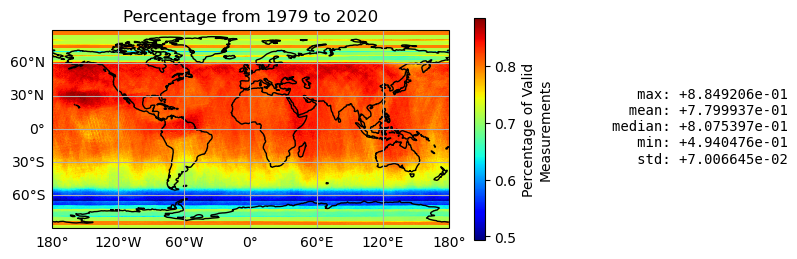

In [6]:
valid_over_time = mask.count('time') / len(mask.time)
valid_over_time = valid_over_time.rename('Percentage of Valid Measurements')
p = plot.projected_map(valid_over_time, show_stats=True, cmap='jet', cbar_kwargs={'shrink':0.6})
p.axes.set_title('Percentage from 1979 to 2020')
p.figure.figsize = (12,5)

The percentage of valid CLARA-A3 measurements over time shows high spatial coverage and robustness, with minor gaps in regions prone to persistent cloud cover: Southern Ocean and Antarctic Area. Indeed, these regions are characterized by persistent cloudiness and the presence of snow/ice surfaces, which complicate the cloud detection, especially during polar night or low sun angle periods. This results in under-detection of clouds or misclassifications, reducing valid retrievals for surface shortwave flux (see [[1]](https://doi.org/10.5194/essd-15-4901-2023), or the [CLARA-A3 PUM](https://www.cmsaf.eu/SharedDocs/Literatur/document/2023/saf_cm_rmib_pum_gac_toa_1_2_pdf.pdf?__blob=publicationFile#page=24.04))

Text(0.5, 0.98, 'Lat-Lon Yearly-Averaged Percentage of Valid Measurements')

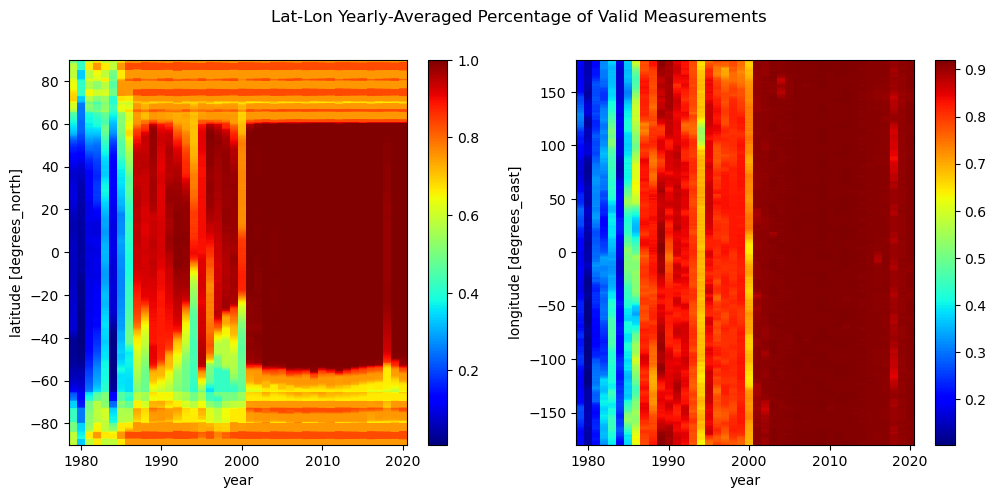

In [7]:
valid_lat_time = mask.count('longitude') / len(mask.longitude)
valid_lon_time = mask.count('latitude') / len(mask.latitude)
fig = plt.figure(1, figsize=(12,5))
ax = fig.add_subplot(121)
Ax = fig.add_subplot(122)
valid_lat_time.groupby('time.year').mean('time').plot(ax=ax, x='year', cmap='jet')
valid_lon_time.groupby('time.year').mean('time').plot(ax=Ax, x='year', cmap='jet')
fig.suptitle(f'Lat-Lon Yearly-Averaged Percentage of Valid Measurements')

The low availability of valid CLARA-A3 surface downwelling shortwave radiation data from 1979 to 1985 is primarily due to the technical and calibration limitations of the early AVHRR sensors on the first NOAA polar orbiting satellites. These issues affected data quality, leading to filtering of scenes and lower overall valid data coverage until improved sensors and additional satellites became operational from the mid-1980s onward (see again the [CLARA-A3 PUM](https://www.cmsaf.eu/SharedDocs/Literatur/document/2023/saf_cm_rmib_pum_gac_toa_1_2_pdf.pdf?__blob=publicationFile#page=24.04))

In [8]:
def mean_map_period(ds, start, stop, W, S):
    selection = ds.sel(time=slice(start, stop))
    time_coord =  np.array(pd.date_range(start, stop, freq='MS'), dtype=np.datetime64)
    ds = selection.assign_coords({'time':('time', time_coord, selection.time.attrs)})
    ds_map = diagnostics.time_weighted_mean(ds, weights=W, skipna=S)
    return ds_map

In [9]:
def get_varname(ds, variable):
    if variable=="downwelling_shortwave":
        varnames = (
            {"SIS", "avg_sdswrf", "SW_flux"}
        )
        
    (varname,) = set(ds.data_vars) & varnames
    return varname

ds_maps = {}
p = []
for request_dict in request_dicts:
    da_maps = {}
    for collection_id, (product, request) in zip(collection_ids, request_dict.items()):
        p.append(product)

        ds = DS[variable][product]
        
        varname=get_varname(ds, variable)
        
        da = ds[varname]
        if product=="CLARA_A3":
            regrid=False
            da_obj = ds[varname]
        else:
            regrid=True
            da = da.drop('time').rename({'forecast_reference_time':'time'}).assign_coords(time=da_obj.time)
            da = diagnostics.regrid(da, da_obj, method='bilinear')
        da.attrs.update({"start": start, "stop": stop})
        da = da*mask
        da_maps[product] = diagnostics.time_weighted_mean(da, weights=True, skipna=True)
        
    ds_maps[variable] = da_maps

In [10]:
ds_timeseries = {}
p = []
for request_dict in request_dicts:
    da_timeseries = {}
    for collection_id, (product, request) in zip(collection_ids, request_dict.items()):
        p.append(product)

        ds = DS[variable][product]
        
        varname=get_varname(ds, variable)
        
        da = ds[varname]
        if product=="CLARA_A3":
            regrid=False
            da_obj = ds[varname]
        else:
            regrid=True
            da = da.drop('time').rename({'forecast_reference_time':'time'}).assign_coords(time=da_obj.time)
            da = diagnostics.regrid(da, da_obj, method='bilinear')
        da.attrs.update({"start": start, "stop": stop})
        
        regrid_dict={'regrid':regrid, 'ds_obj':da_obj}

        SkipNa={'SKIP': True}

        Mask = {'mask': mask}
        
        dataarrays = []
        for region, slices in region_slices.items():
            dall = {}
            dall.update(slices)
            dall.update(regrid_dict)
            dall.update(SkipNa)
            dall.update(Mask)
            da_ts = spatial_weighted_mean(da,
                                          lon_slice=dall['lon_slice'],
                                          lat_slice=dall['lat_slice'],
                                          regrid=dall['regrid'],
                                          ds_obj=dall['ds_obj'],
                                          SKIP=dall['SKIP'],
                                          mask=dall['mask'])
            dataarrays.append(da_ts.expand_dims(region=[region]))
        
        da = xr.concat(dataarrays, "region")
        da.attrs.update({"start": start, "stop": stop})
        da_timeseries[product] = da.rename(variable)
    ds_timeseries[variable] = da_timeseries

(plot-spatial-weighted-time-series)=
### 3. Spatial weighted time series

The analysis shifts to temporal consistency by aggregating the data over the three defined global regions. For each domain (Global, Northern Hemisphere, and Southern Hemisphere), three key plots are generated. The monthly mean climatology plot averages the time series by month to reveal the characteristic annual cycle and effectively quantify any seasonal differences or systematic offsets between CLARA-A3 and ERA5, which are further investigated through the calculation of the climatological bias and Root Mean Square Error (RMSE).

In [11]:
lw_ts = xr.concat([ds_timeseries['downwelling_shortwave'][k] for k in ds_timeseries['downwelling_shortwave'].keys()], 
                  dim='product', 
                  coords='minimal').assign_coords({'product': [k for k in ds_timeseries['downwelling_shortwave'].keys()]})
monthly_clim = lw_ts.groupby('time.month').mean('time')

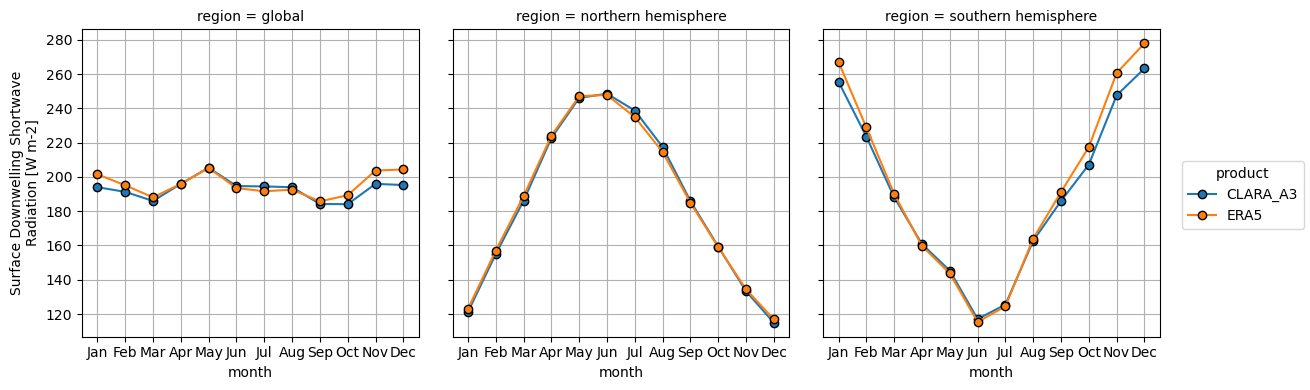

In [12]:
t1 = monthly_clim.plot(col='region', hue='product', figsize=(12,4), marker='o', markeredgecolor='k')
for ax in t1.axs.flatten():
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid()
    

The global and hemispheric time series indicate strong coherence between CLARA-A3 and ERA5 across the 1979–2020 period. Differences are generally small, with some seasonal variations: discrepancies appear mainly from September to February in the Southern Hemisphere, which also influences the global curve. Both hemispheric time series exhibit clear seasonality consistent with boreal and austral cycles. By visual extrapolation, global time series suggest a globally-averaged downward solar radiation of about $190\, W m^{-2}$, slightly higher than the widely accepted value of about $160-170\, W m^{-2}$ ([[2]](https://doi.org/10.1017/9781009157896)), likely due to the masking carried out (see discussion below).

The monthly climatological bias between the CLARA A3 and ERA5 shortwave flux datasets is computed by subtracting the ERA5 shortwave flux time series from the CLARA A3 time series.
Next, the code plots the resulting monthly climatological bias. A multi panel figure is generated, with a separate plot for each geographic region. The three panels show the monthly bias (CLARA-A3 minus ERA5) for global, Northern Hemisphere, and Southern Hemisphere averages over the period 1979–2020.


In [13]:
bias_clara_era = lw_ts.sel(product='CLARA_A3') - lw_ts.sel(product='ERA5')
monthly_clim_bias = bias_clara_era.groupby('time.month').mean('time')

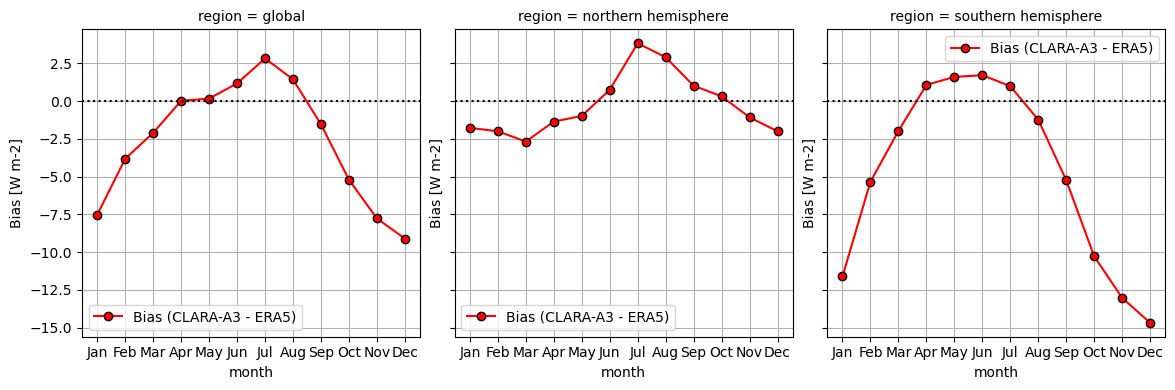

In [14]:
clim_bias = monthly_clim_bias.plot(col='region', figsize=(12,4), marker='o', markeredgecolor='k', color='red', label='Bias (CLARA-A3 - ERA5)') #.resample(time='1M').mean()
for ax in clim_bias.axs.flatten():
    ax.axhline(0., color='k', ls=':')
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid()
    ax.set_ylabel('Bias [W m-2]')
    ax.legend(loc='best')

The global bias oscillates seasonally, ranging from about $–9 W\, m^{-2}$ in January to $\sim +3 W\, m^{-2}$ in July. Negative values dominate most of the year, indicating that CLARA-A3 generally reports lower shortwave flux than ERA5, except during boreal summer (June–August), when CLARA-A3 is slightly higher.
In the Northern Hemisphere, the pattern is similar to the global curve but more pronounced: i) in winter (Jan–Feb) CLARA-A3 is $\sim W\, m^{-2}$ lower than ERA5; ii) in summer (Jun–Jul), CLARA-A3 exceeds ERA5 by up to $\sim +4 W\, m^{-2}$.
In the Southern Hemisphere, i) in the Austral summer (Dec–Jan), CLARA-A3 is $\sim 12–15 W\, m^{-2}$ lower than ERA5; ii) in Austral winter (Jun–Jul), the bias is slightly positive. 
Overall, the bias is seasonally dependent and hemisphere-specific, not constant throughout the year.

The code below calculates the monthly climatological Root Mean Square Error (RMSE) between the CLARA A3 and ERA5 shortwave flux datasets and then visualizes the result. Next, the code plots the resulting monthly RMSE. A multi panel figure is generated, with a separate plot for each geographic region. The three panels display the monthly Root Mean Square Error (RMSE) between CLARA-A3 and ERA5 for global, Northern Hemisphere, and Southern Hemisphere averages over 1979–2020.


In [15]:
monthly_clim_rmse = bias_clara_era.groupby('time.month').std('time')

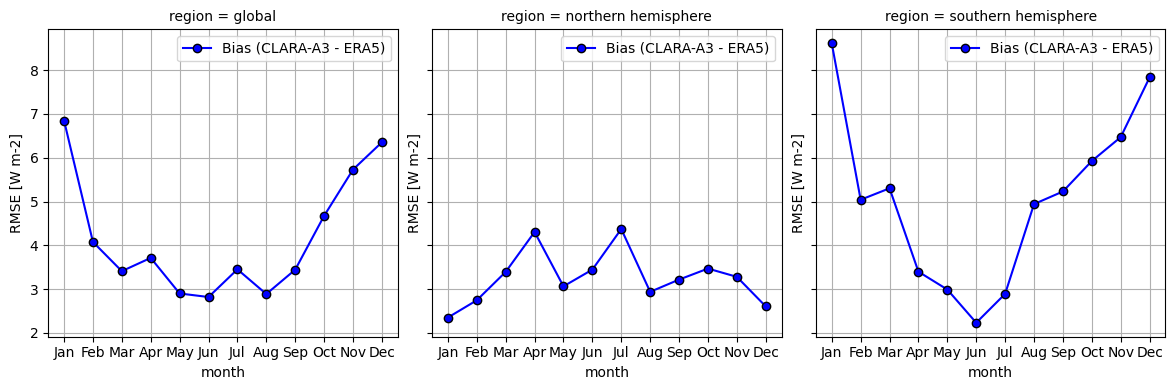

In [16]:
clim_rmse = monthly_clim_rmse.plot(col='region', figsize=(12,4), marker='o', markeredgecolor='k', color='blue', label='Bias (CLARA-A3 - ERA5)')
for ax in clim_rmse.axs.flatten():
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid()
    ax.set_ylabel('RMSE [W m-2]')
    ax.legend(loc='best')

The most evident feature is the pronounced "U-shape" in the Southern Hemisphere plot. The error does not remain constant but scales drastically with the solar cycle, peaking at $\sim 8.5 W\, m^{-2}$ during the austral summer (December–January) and dropping to $\sim 2.2 W\, m^{-2}$ in the austral winter (June).
The Global plot (left) mirrors the Southern Hemisphere's pattern, with high errors in December–January ($\sim 6.8 W\, m^{-2}$) and lower errors in June–July ($\sim 2.8 W\, m^{-2}$).
The Northern Hemisphere shows a much flatter and lower error profile, fluctuating between $2.3$ and $4.4 W\, m^{-2}$. 


(plot-time-weighted-means)=
### 4. Time-weighted mean maps
This section provides the long-term visual assessment of spatial consistency. The code generates two global mean maps, one for the CLARA-A3 data and one for the ERA5 data, averaging the monthly fluxes over the 1979–2020 period. This visualisation allows for a direct qualitative comparison of the spatial distribution of the shortwave flux. Both products are displayed side by side using the same colour scale and geographic projection, which helps visually identify regions of good agreement or regions where systematic biases (such as those found in the time series analysis) are most pronounced geographically.

Text(0.5, 0.98, 'Mean map on the period 1979-2020')

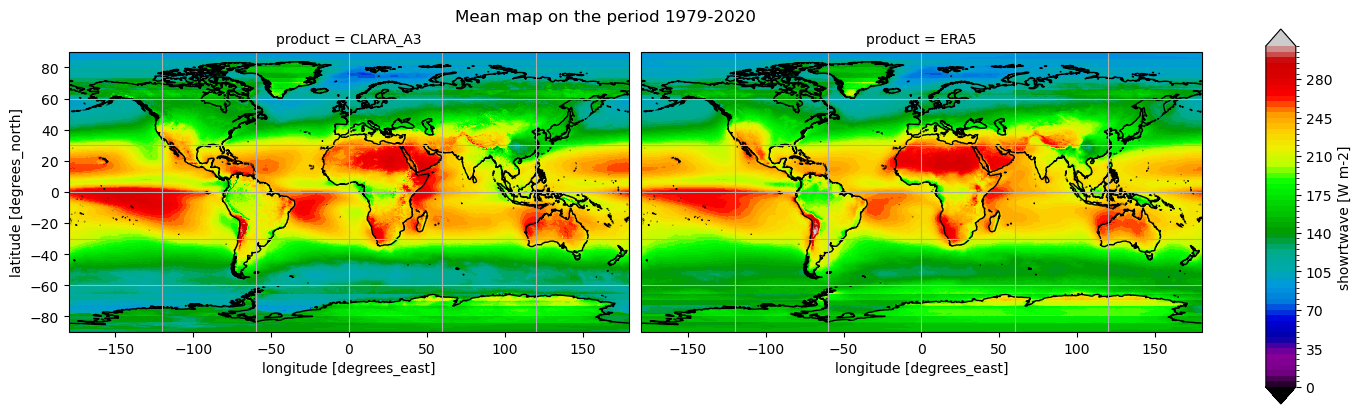

In [17]:
p_to_show = ['CLARA_A3', 'ERA5']
lw_maps = xr.concat([ds_maps['downwelling_shortwave'][p] for p in p_to_show], dim='product').assign_coords({'product': p_to_show})
lw_maps_masked = lw_maps
times = lw_ts.time
p1 = lw_maps_masked.plot(figsize=(12,5),
                         col='product', 
                         col_wrap=2,
                         subplot_kws={'projection': ccrs.PlateCarree()},
                         levels=range(0, 315, 5),
                         extend="both",
                         cmap="nipy_spectral",
                         add_colorbar=False,
                         transform=ccrs.PlateCarree())
for ax in p1.axs.flat:  # loop through the map axes
    subplotspec = ax.get_subplotspec()
    if subplotspec.is_last_row():
        ax.xaxis.set_visible(True)
    if subplotspec.is_first_col():
        ax.yaxis.set_visible(True)
    ax.coastlines('50m')
    ax.gridlines()
p1.fig.set_layout_engine("compressed")
cax = p1.fig.add_axes([1.05, 0.1, 0.025, 0.75])
p1.add_colorbar(cax=cax, orientation='vertical', label=r'showrtwave [W m-2]')
p1.fig.suptitle(f'Mean map on the period {times.dt.year[0].values}-{times.dt.year[-1].values}')

Both datasets exhibit similar spatial patterns, with maximum values over the subtropical oceans and continental low-latitude regions, and minima near the poles. The Intertropical Convergence Zone (ITCZ) appears as a pronounced high-radiation band across the equator in both products. Differences are subtle but visible: ERA5 tends to show slightly higher fluxes over tropical land areas and in the Southern Hemisphere (Antarctica), compared to CLARA-A3. Overall, the spatial agreement is strong, confirming that both datasets capture the global radiation climatology well, with minor systematic differences likely linked to clouds, which are probably too few in ERA5 ([[3]](https://doi.org/10.1007/s00382-024-07182-6)).

This code performs a multi-step analysis comparing the CLARA-A3 Surface Incoming Shortwave product with the ERA5 Shortwave Radiation Flux data, over the period 1979–2020, ultimately generating two geographical maps: one for the Mean Bias and one for the Root Mean Square Error (RMSE).

In [18]:
mask = xr.where(navg_obs_month==avgdays_in_month, 1, np.nan) 

In [19]:
da_obj = DS[variable]['CLARA_A3']['SIS']
da_era5 = DS[variable]['ERA5']['avg_sdswrf'].drop('time').rename({'forecast_reference_time':'time'}).assign_coords(time=da_obj.time)
bias = (da_obj - 
        diagnostics.regrid(da_era5,
                           da_obj, method='bilinear'))*mask
timeavg_bias = bias.mean('time').rename('mean_bias')
times = lw_ts.time

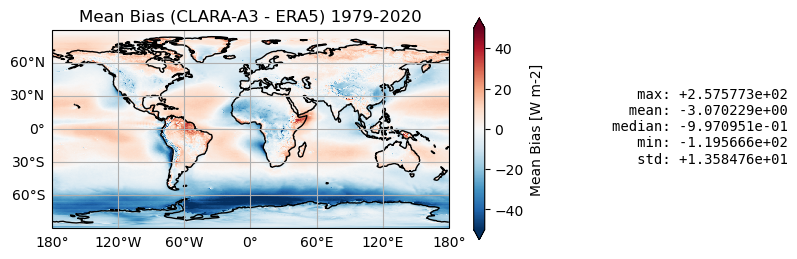

In [20]:
p2 = plot.projected_map(timeavg_bias, show_stats=True, cmap='RdBu_r', cbar_kwargs={'shrink':0.6, 'label': 'Mean Bias [W m-2]'}, vmin=-50, vmax=50)
p2.axes.set_title(f'Mean Bias (CLARA-A3 - ERA5) {times.dt.year[0].values}-{times.dt.year[-1].values}')
p2.figure.figsize = (12,5)

A strong, consistent negative bias (blue) dominates the entire Southern Ocean and Antarctica. This means the CLARA-A3 product is consistently lower than the ERA5 product. Particularly, ERA5 has higher insolation over China and the Tibetan Plateau area, which can be addressed to the underestimation of the cloud cover (see [[4]](https://doi.org/10.1155/adme/5002403)).

In [21]:
time_rmse = bias.std('time').rename('time_rmse')

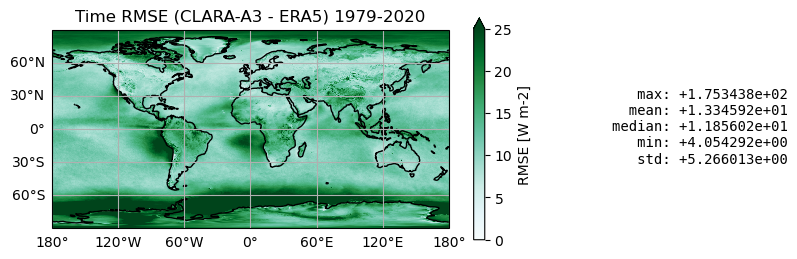

In [22]:
p3 = plot.projected_map(time_rmse, show_stats=True, cmap='BuGn', cbar_kwargs={'shrink':0.6, 'label': 'RMSE [W m-2]'}, vmin=0, vmax=25)
p3.axes.set_title(f'Time RMSE (CLARA-A3 - ERA5) {times.dt.year[0].values}-{times.dt.year[-1].values}')
p3.figure.figsize = (12,5)

RMSE measures the magnitude of the typical difference or variability over time, with higher values indicating greater time-varying differences between the two products.
The most apparent pattern is the RMSE significantly higher in the polar and high latitude regions, especially over the Southern Ocean and Antarctica, compared to the generally lower values seen over the tropics and mid-latitudes. This indicates the two datasets have the greatest temporal disagreement and variability in their differences near the poles.

(plot-spatial-weighted-zonal-means)=
### 5. Spatially weighted zonal mean profiles
This final section shifts the focus from global maps to a quantitative comparison of the latitudinal distribution of the shortwave flux. The code calculates the Zonal Mean profile for both CLARA-A3 and ERA5 by spatially weighting the data at each latitude line (using the cosine of latitude to account for grid cell area) and averaging over all longitudes and the entire time period (1979–2020). Plotting these two profiles on a single axis allows for immediate and precise identification of any systematic latitudinal biases, revealing how the differences between the satellite product and the reanalysis vary across distinct climate zones, from the poles to the equator.

Text(0.5, 0, 'downwelling_shortwave [W m-2]')

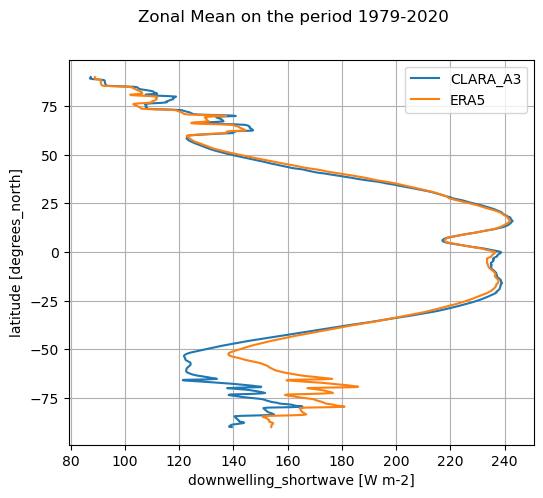

In [23]:
fig=plt.figure(5, figsize=(6,5))
ax1 = fig.add_subplot(111)
fig.suptitle(f'Zonal Mean on the period {times.dt.year[0].values}-{times.dt.year[-1].values}')
da_maps = ds_maps[variable]
ax=ax1
for product, da in da_maps.items():
    da = diagnostics.spatial_weighted_mean(da, dim="longitude")
    da.plot(ax=ax, y="latitude", label=product)
ax.legend(loc='best')
ax.grid()
ax.set_title('')
ax.set_xlabel(f"{variable} [W m-2]")

Both datasets exhibit very similar profiles, with maximum values near the equator ($\sim 240 W\, m^{-2}$) and a gradual decrease toward the poles, reaching $\sim 100–140 W\, m^{-2}$ at high latitudes. The agreement between the two datasets is strong across all latitudes, and no systematic bias is evident—differences are small and vary locally, with occasional minor deviations in the Southern Hemisphere high latitudes. Overall, the figure confirms that CLARA-A3 and ERA5 provide consistent estimates of the global radiation climatology when averaged zonally.

#### Discussion and applications

The comparison between the satellite-derived Surface Downwelling Shortwave Flux from CLARA-A3 and the ERA5 reanalysis reveals a high degree of spatial and temporal consistency, making both datasets valuable for solar energy applications [[5]](https://doi.org/10.1016/j.solener.2019.02.058). 

CLARA-A3 provides robust global coverage, with minor data gaps primarily in regions characterised by persistent cloudiness and reflective ice/snow surfaces, such as the Southern Ocean and Antarctica. These gaps arise from challenges in cloud detection under low solar angles or during polar night, as well as the complex reflectance of ice and snow, which complicate retrievals ([[1]](https://doi.org/10.5194/essd-15-4901-2023), [CLARA-A3 PUM](https://www.cmsaf.eu/SharedDocs/Literatur/document/2023/saf_cm_rmib_pum_gac_toa_1_2_pdf.pdf?__blob=publicationFile#page=24.04)). Additionally, data availability in the early period (1979–1985) is limited due to technical issues with early AVHRR sensors, with improvements seen in later satellite generations ([CLARA-A3 PUM](https://www.cmsaf.eu/SharedDocs/Literatur/document/2023/saf_cm_rmib_pum_gac_toa_1_2_pdf.pdf?__blob=publicationFile#page=24.04)).

Over the 1979-2020 period, global and hemispheric time series show strong coherence and seasonal agreement between CLARA-A3 and ERA5. Differences are generally small but seasonally dependent and region-specific, with the Southern Hemisphere exhibiting the largest biases during austral summer. Both datasets capture key spatial patterns well, including maxima along the ITCZ and minima near the poles. ERA5 tends to report slightly higher fluxes over tropical land and Antarctic regions, likely influenced by differences in cloud representation [[1]](https://doi.org/10.5194/essd-15-4901-2023).

Monthly bias analysis reveals a systematic oscillation where CLARA-A3 generally underestimates shortwave flux in winter and overestimates in summer relative to ERA5, with RMSE values peaking at high latitudes, particularly over the Southern Ocean.

For solar energy applications, where accurate representation of irradiance during sunlit hours is crucial, CLARA-A3 is often preferred. Being satellite-based, it better captures the actual optical cloud properties and avoids the structural overestimation found in ERA5, thus providing a more conservative resource estimate. However, users should consider CLARA-A3’s "missing data" during polar night and low solar angles, which inflates global mean radiation estimates by excluding zero-flux periods [[1]](https://doi.org/10.5194/essd-15-4901-2023).

The complementarity of CLARA-A3 and ERA5 underpins their combined use for solar energy resource assessment. CLARA-A3 provides observational validation, while ERA5 offers continuous spatial interpolation and coverage, which is particularly beneficial where satellite data are sparse or unavailable. Recognizing regional and seasonal biases—including polar and early satellite era limitations—may require multi-source bias correction ([[6]](https://doi.org/10.1016/j.rse.2024.114472), [[7]](https://doi.org/10.1109/JSTARS.2023.3346032)).

Overall, CLARA-A3 and ERA5 together provide a high-quality, coherent surface downwelling shortwave radiation climatology suitable for solar energy applications worldwide, supporting reliable energy yield modeling and planning while accounting for known dataset limitations.


## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.5194/essd-15-4901-2023) Karlsson, K. G., Stengel, M., Meirink, J. F., Riihelä, A., Trentmann, J., Akkermans, T., ... & Hollmann, R. (2023). CLARA-A3: The third edition of the AVHRR-based CM SAF climate data record on clouds, radiation and surface albedo covering the period 1979 to 2023. Earth System Science Data, 15(11), 4901-4926. https://doi.org/10.5194/essd-15-4901-2023

[[2]](https://doi.org/10.1017/9781009157896) Masson-Delmotte, V., Zhai, P., Pirani, A., Connors, S. L., Péan, C., Berger, S., ... & Zhou, B. (2021). Climate change 2021: the physical science basis. Contribution of working group I to the sixth assessment report of the intergovernmental panel on climate change, 2(1), 2391. https://doi.org/10.1017/9781009157896

[[3]](https://doi.org/10.1007/s00382-024-07182-6) Dai, A. (2024). The diurnal cycle from observations and ERA5 in precipitation, clouds, boundary layer height, buoyancy, and surface fluxes. Climate Dynamics, 62(7), 5879-5908. https://doi.org/10.1007/s00382-024-07182-6

[[4]](https://doi.org/10.1155/adme/5002403) Zeng, Y., Yang, L., Tong, Z., Jiang, Y., Abulikemu, A., Zhou, Y., ... & Li, X. (2025). Total Cloud Cover in Xinjiang Uygur Autonomous Region, Northwest China: A Comparison of ERA5 and ISCCP With FY4A. Advances in Meteorology, 2025(1), 5002403. https://doi.org/10.1155/adme/5002403

[[5]](https://doi.org/10.1016/j.solener.2019.02.058) Babar, B., Graversen, R., & Boström, T. (2019). Solar radiation estimation at high latitudes: Assessment of the CMSAF databases, ASR and ERA5. Solar Energy, 182, 397-411. https://doi.org/10.1016/j.solener.2019.02.058

[[6]](https://doi.org/10.1016/j.rse.2024.114472) Urraca, R., Trentmann, J., Pfeifroth, U., & Gobron, N. (2024). Can satellite products monitor solar brightening in Europe?. Remote Sensing of Environment, 315, 114472. https://doi.org/10.1016/j.rse.2024.114472

[[7]](https://doi.org/10.1109/JSTARS.2023.3346032) Tian, Q., Zhang, S., Duan, W., & Ming, G. (2023). Evaluation of downward shortwave radiation products over the Loess Plateau. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 17, 3167-3180. https://doi.org/10.1109/JSTARS.2023.3346032